#### Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from scipy import stats
import statsmodels.api as sm

In [3]:
import warnings

In [4]:
import datetime
from dateutil.relativedelta import *

In [5]:
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [6]:
import matplotlib.pyplot as plt

In [7]:
from itertools import product

#### Data reading

In [8]:
wdata = pd.read_csv(
    'WAG_C_M.csv',
    ';',
    index_col=['month'],
    parse_dates=['month'],
    dayfirst=True)

In [9]:
wdata.shape

(284, 1)

In [10]:
wdata.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


STL-декомпозиция ряда:

<Figure size 864x360 with 0 Axes>

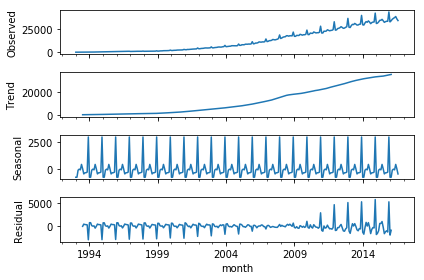

In [11]:
plt.figure(figsize=(12, 5));
sm.tsa.seasonal_decompose(wdata.WAG_C_M).plot();
plt.show();

#### Data diff

Введем столбцы для сезонного и обычного дифференцирования:

In [12]:
wdata['daily_diff12'] = wdata['WAG_C_M'] - wdata['WAG_C_M'].shift(12)
wdata['diff12'] = wdata['daily_diff12'] - wdata['daily_diff12'].shift(1)

Графики для исходных и продифференцированных данных:

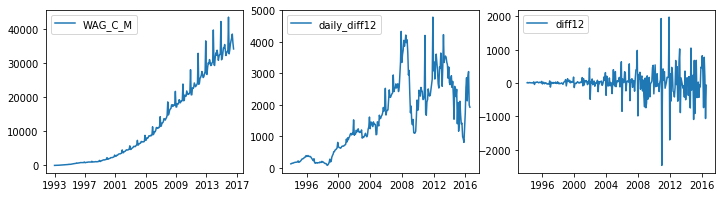

In [13]:
plt.figure(figsize = (12, 3))
plt.subplot(1,3,1)
plt.plot(wdata.WAG_C_M, label = 'WAG_C_M')
plt.legend()
plt.subplot(1,3,2)
plt.plot(wdata.daily_diff12, label = 'daily_diff12')
plt.legend()
plt.subplot(1,3,3)
plt.plot(wdata.diff12, label = 'diff12')
plt.legend()
plt.show()

Проверка по критерию Дика-Фуллера:

In [14]:
statcrit_wag = sm.tsa.stattools.adfuller(wdata.WAG_C_M)
statcrit_daily_diff12 = sm.tsa.stattools.adfuller(wdata.daily_diff12.dropna())
statcrit_diff12 = sm.tsa.stattools.adfuller(wdata.diff12.dropna())

In [15]:
[statcrit_wag[1], statcrit_daily_diff12[1], statcrit_diff12[1]]

[0.9918495954854734, 0.5463146002048518, 9.288290156337357e-08]

Критерий Дика-Фуллера отвергает гипотезу нестационарности дважды продифференцированного ряда. Однако мне он не нравится -- визуально по третьему графику понятно, что дисперсия сильно меняется. Попробую преобразование Бокса-Кокса для исходных данных:

#### Transforming

Столбец для преобразованных данных:

In [16]:
wdata['wag_box'], lmbda = stats.boxcox(wdata.WAG_C_M)

In [17]:
wdata.head()

,WAG_C_M,daily_diff12,diff12,wag_box
month,,,,
1993-01-01,15.3,NaN,NaN,3.990393
1993-02-01,19.1,NaN,NaN,4.458758
1993-03-01,23.6,NaN,NaN,4.931635
1993-04-01,30.6,NaN,NaN,5.549430
1993-05-01,37.5,NaN,NaN,6.063406


In [18]:
lmbda

0.2632017541844584

STL-декомпозиция ряда преобразованных значений (ничего интересного, можно листать дальше):

<Figure size 864x360 with 0 Axes>

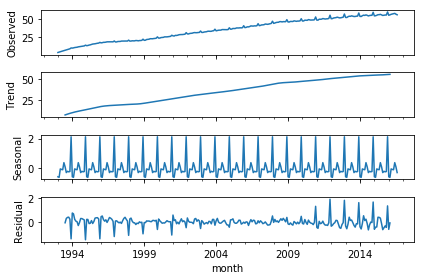

In [19]:
plt.figure(figsize = (12, 5));
sm.tsa.seasonal_decompose(wdata.wag_box).plot();
plt.show();

Заново выполняю сезонное и обычное дифференцирование:

In [20]:
wdata['daily_diff12'] = wdata['wag_box'] - wdata['wag_box'].shift(12)
wdata['diff12'] = wdata['daily_diff12'] - wdata['daily_diff12'].shift(1)

Графики:

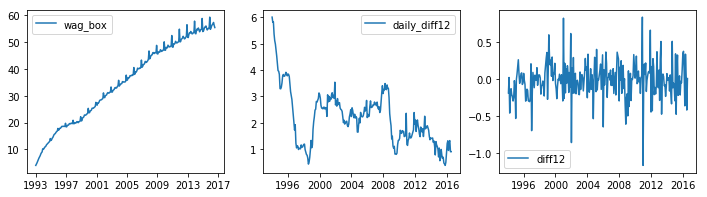

In [21]:
plt.figure(figsize = (12, 3))
plt.subplot(1,3,1)
plt.plot(wdata.wag_box, label = 'wag_box')
plt.legend()
plt.subplot(1,3,2)
plt.plot(wdata.daily_diff12, label = 'daily_diff12')
plt.legend()
plt.subplot(1,3,3)
plt.plot(wdata.diff12, label = 'diff12')
plt.legend()
plt.show()

Проверка по критерию Дика-Фуллера:

In [22]:
statcrit_wag = sm.tsa.stattools.adfuller(wdata.wag_box)
statcrit_daily_diff12 = sm.tsa.stattools.adfuller(wdata.daily_diff12.dropna())
statcrit_diff12 = sm.tsa.stattools.adfuller(wdata.diff12.dropna())

In [23]:
[statcrit_wag[1], statcrit_daily_diff12[1], statcrit_diff12[1]]

[0.6968987634832706, 0.014697133494791775, 5.203603715821735e-08]

Критерий Дика-Фуллера отвергает гипотезу нестационарности ряда с сезонным дифференцированием, но как-то ненадежненько (p = 0.014). Гораздо более надежно отвергается нестационарность ряда после двойного дифференцироания. Модель будет строиться именно для него 

#### Pickup a model

Графики ACF и PACF

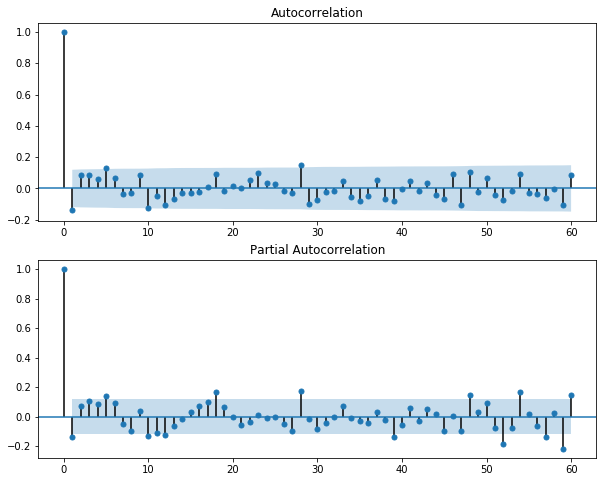

In [24]:
plt.figure(figsize = (10,8))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(wdata.diff12.dropna().values.squeeze(), lags=60, ax=ax)
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(wdata.diff12.dropna().values.squeeze(), lags=60, ax=ax)
plt.show()

##### Q = 0; q = 1; P = 0; p = 5;

In [25]:
ps = range(0, 6)
d = 1
qs = range(0, 2)
Ps = range(0, 1)
D = 1
Qs = range(0, 1)

In [26]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

Количество комбинаций для перебора

In [27]:
len(parameters_list)

12

Перебор параметров аккуратно слизан из **wine.ipynb**

In [28]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            wdata.wag_box,
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))


Эксепшен вылетел всего один раз

In [29]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
9   (5, 0, 0, 0) -2.104961
6   (3, 1, 0, 0) -1.392772
10  (5, 1, 0, 0) -1.292344
8   (4, 1, 0, 0) -0.332499
7   (4, 0, 0, 0)  1.433905


Наилучшая модель:

In [30]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   7.052
Date:                            Tue, 22 Jan 2019   AIC                             -2.105
Time:                                    18:15:29   BIC                             19.508
Sample:                                01-01-1993   HQIC                             6.573
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1503      0.047     -3.215      0.001      -0.242      -0.059
ar.L2          0.0657      0.070   

График остатков:

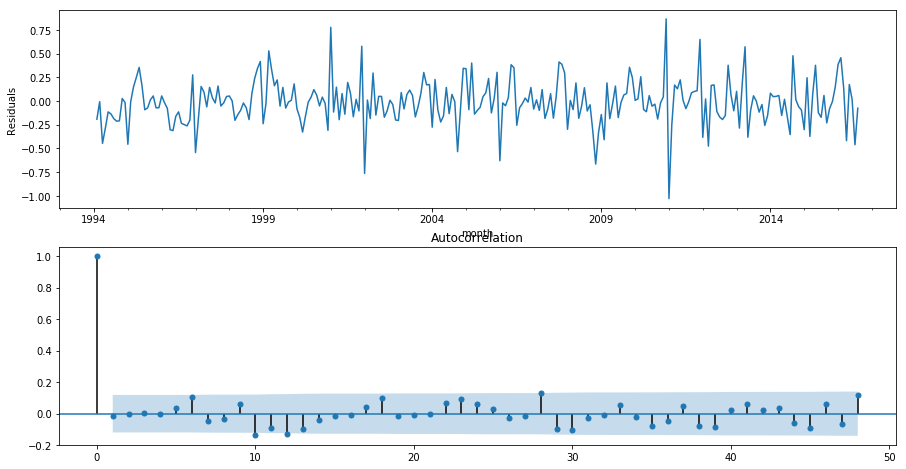

In [31]:
plt.figure(figsize = (15,8))
plt.subplot(2,1,1)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Критерий Стьюдента на несмещенность остатков:

In [32]:
stats.ttest_1samp(best_model.resid.dropna(), 0)

Ttest_1sampResult(statistic=0.6704439664767088, pvalue=0.5031215587324289)

Критерий Дика-Фуллера на стационарность остатков:

In [33]:
sm.tsa.stattools.adfuller(best_model.resid.dropna())

(-20.456310574401112,
 0.0,
 0,
 283,
 {'1%': -3.453670163592738,
  '10%': -2.5722411158835796,
  '5%': -2.8718077069772248},
 -12.348620120827036)

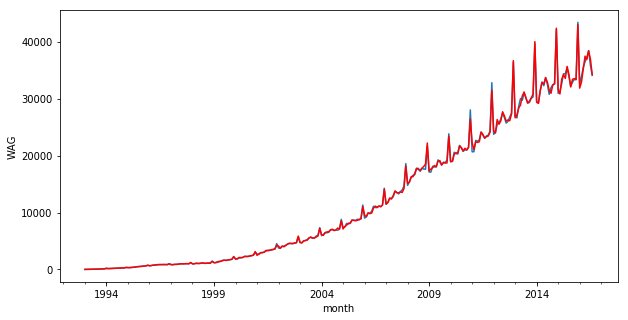

In [34]:
wdata['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (10,5))
wdata.WAG_C_M.plot()
wdata.model.dropna().plot(color='r')
plt.ylabel('WAG')
plt.show()

#### Прогноз

Количество месяцев

In [35]:
nmonth = 36

In [63]:
wag2data = wdata[['WAG_C_M']]
date_list = [
    datetime.datetime.strptime(
        wdata.index[-1].strftime("%Y-%m-%d"),
        "%Y-%m-%d")
    + relativedelta(months = x) for x in range(0,nmonth)]
future = pd.DataFrame(index = date_list, columns= wag2data.columns)
wag2data = pd.concat([wag2data, future])
wag2data['forecast'] = invboxcox(
    best_model.predict(start=wdata.shape[0],end=wdata.shape[0] + nmonth - 1),
    lmbda)

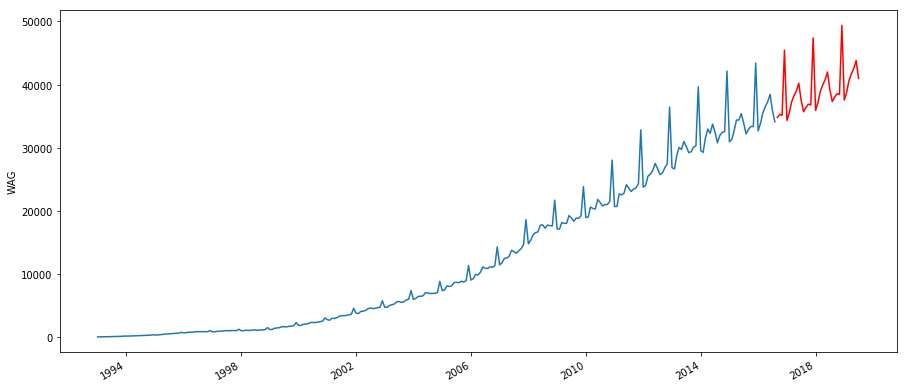

In [37]:
plt.figure(figsize = (15,7))
wag2data.WAG_C_M.plot()
wag2data.forecast.plot(color='r')
plt.ylabel('WAG')
plt.show()